In [93]:
# Data handling and processing
import pandas as pd
import numpy as np
import random

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation and utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', message="is_sparse is deprecated")
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import roc_auc_score, brier_score_loss

# XGBoost
import xgboost as xgb
print(xgb.__version__)

# Progress display
import tqdm

# Statsmodels
import statsmodels.api as sm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchmetrics
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss

# Optuna for hyperparameter optimization
import optuna
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import log_loss
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

2.1.1


### Summary of Approach

In this notebook, we perform hyperparameter optimization and model evaluation for a binary classification task using a deep learning model. The steps are as follows:

1. **Data Preparation**: The dataset is split into training, validation, and test sets, ensuring stratification to maintain class distribution.

2. **Model Definition**: A feedforward neural network is defined using PyTorch, featuring two hidden layers with Leaky ReLU activations, batch normalization, and dropout for regularization.

3. **Baseline Model Evaluation**: The initial model is trained and evaluated on the test set to establish baseline performance metrics, including log loss, AUC (Area Under the ROC Curve), and Brier score.

4. **Hyperparameter Optimization**: Using Optuna, we tune hyperparameters, including the number of units in hidden layers, dropout rate, learning rate, and weight decay. The objective is to minimize the validation log loss.

5. **Model Training with Best Parameters**: The model is retrained using the best-found hyperparameters. Training and validation losses are tracked over epochs to monitor performance.

6. **Updated Model Evaluation**: After hyperparameter selection, the model's performance is evaluated on the test set again to compare results. Additionally, the model is fine-tuned, and its performance is reassessed post weight and bias updates.

7. **Visualization**: Training and validation losses are plotted to assess model performance and convergence behavior throughout the training process.

This structured approach provides a comprehensive evaluation of the model's capabilities, allowing for effective hyperparameter tuning and performance comparison across different training stages.


In [4]:
def plot_errors(train_losses, val_losses):
    """
    Plots training and validation losses over epochs.
    
    Parameters:
    - train_losses: List of training loss values for each epoch.
    - val_losses: List of validation loss values for each epoch.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()


In [5]:
full_data = pd.read_csv('~/data/phasing/NA12878/6finalized/exonPhasedSites_final_matrix_24828_finalized.tsv',sep='\t')
full_data["MAF"] = full_data["EUR_MAF"]
full_data["lag_MAF"] = full_data["lag_EUR_MAF"]
full_data["min_MAF"] = full_data["min_EUR_MAF"]
full_data["diff_MAF"] = full_data["diff_EUR_MAF"]
# make interaction between log10distance and r2
full_data["log10distance_intxn_r2"] = full_data["log10_distance"] * full_data["r2"]
full_data["log10distance_intxn_minMAF"] = full_data["log10_distance"] * full_data["min_MAF"]
full_data["log10distance_intxn_diffMAF"] = full_data["log10_distance"] * full_data["diff_MAF"]
full_data_sub = full_data[["chr", "pos", "geneID", "error", "d", "r2", "AF", "MAF", "lag_MAF", "min_MAF", "diff_MAF", "log10_distance","log10distance_intxn_r2","log10distance_intxn_minMAF","log10distance_intxn_diffMAF"]]

full_data_sub.head()

,chr,pos,geneID,error,d,r2,AF,MAF,lag_MAF,min_MAF,diff_MAF,log10_distance,log10distance_intxn_r2,log10distance_intxn_minMAF,log10distance_intxn_diffMAF
0,chr1,909419,ENSG00000187583,NaN,1.000,0.024,0.111222,0.111222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,914852,ENSG00000187642,NaN,0.872,0.334,0.512580,0.487420,0.1839,0.1839,0.2167,NaN,NaN,NaN,NaN
2,chr1,914940,ENSG00000187642,0.0,1.000,0.914,0.509585,0.490415,0.4006,0.4006,0.0099,1.944483,1.777257,0.778960,0.019250
3,chr1,916549,ENSG00000187642,0.0,1.000,0.503,0.758586,0.241414,0.4105,0.2416,0.1689,3.206556,1.612898,0.774704,0.541587
4,chr1,949608,ENSG00000187608,NaN,0.740,0.264,0.338858,0.338858,0.2416,0.2416,0.1510,NaN,NaN,NaN,NaN


In [6]:
# Group by 'geneID', sort within each group by 'chr' and 'pos', and drop the first entry of each group
filtered_df = full_data_sub.groupby('geneID').apply(
    lambda x: x.sort_values(['chr', 'pos']).iloc[1:]  # Remove the first row after sorting
).reset_index(drop=True)  # Reset index after filtering
filtered_df.shape
filtered_df.head()

,chr,pos,geneID,error,d,r2,AF,MAF,lag_MAF,min_MAF,diff_MAF,log10_distance,log10distance_intxn_r2,log10distance_intxn_minMAF,log10distance_intxn_diffMAF
0,chr1,196642533,ENSG00000000971,0.0,0.740,1.000,0.468251,0.468251,0.2604,0.2604,0.0000,2.477121,2.477121,0.645042,0.000000
1,chr1,196646387,ENSG00000000971,0.0,0.443,0.079,0.257188,0.257188,0.2604,0.2604,0.0040,3.585912,0.283287,0.933771,0.014344
2,chr1,196682947,ENSG00000000971,0.0,1.000,0.019,0.479034,0.479034,0.2644,0.2644,0.1591,4.563006,0.086697,1.206459,0.725974
3,chr6,143823112,ENSG00000001036,0.0,1.000,0.544,0.170128,0.170128,0.2247,0.2247,0.0000,3.844415,2.091362,0.863840,0.000000
4,chr6,143825104,ENSG00000001036,0.0,1.000,0.091,0.089057,0.089057,0.2247,0.2247,0.0477,3.299289,0.300235,0.741350,0.157376


In [171]:
print(filtered_df.shape)

(17459, 15)


In [7]:
filtered_data = filtered_df
#X = filtered_data[["log10_distance", "d", "r2", "min_MAF", "diff_MAF","log10distance_intxn_minMAF","log10distance_intxn_r2","log10distance_intxn_diffMAF"]]  # Features dataframe
X = filtered_data[["d", "r2", "min_MAF", "diff_MAF","log10_distance", "log10distance_intxn_minMAF","log10distance_intxn_r2","log10distance_intxn_diffMAF"]]  # Features dataframe
#X2 = filtered_data[["d", "r2", "min_MAF", "diff_MAF", "log10distance_intxn_minMAF","log10_distance"]]  # Features dataframe
#X3 = filtered_data[["d", "r2", "min_MAF", "diff_MAF", "log10distance_intxn_r2","log10_distance"]] 
#X4 = filtered_data[["d", "r2", "min_MAF", "diff_MAF", "log10_distance"]]
#X = X2
y = filtered_data[["error"]]    # Binary outcome

In [8]:
X.shape[1]

8

### SNP level multi-layer fully connected forward NN binary classification model

- Data Splitting:
    - You split your dataset into a training/testing set and a separate validation set.
    - The training/testing set is used for training the model and tuning hyperparameters.
    - The validation set is reserved for final evaluation, ensuring an unbiased estimate of model performance.
    
- Hyperparameter Tuning:
    - You ran a hyperparameter optimization process (e.g., with Optuna) on the training/testing set.
    - During this process, various configurations of hyperparameters (such as learning rate, dropout rate, and weight decay) were tested.
    - The best combination of hyperparameters was selected based on the performance on the testing portion of the training/testing set.

- Model Evaluation with Best Parameters:
    - After identifying the best hyperparameters, you retrained the model on the entire training/testing set with these optimal parameters.
    - You then evaluated the model's performance on the validation set to get an unbiased final assessment.

In [77]:


# Initial split into train and test with stratification
X_final_train, X_final_test, y_final_train, y_final_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Further split the training set into training and validation with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_final_train, y_final_train, test_size=0.25, random_state=42, stratify=y_final_train
)

# Convert the train, validation, and test sets to PyTorch tensors
train_features = torch.tensor(X_train.to_numpy()).float()
train_targets = torch.tensor(y_train.to_numpy()).float().unsqueeze(1)  # Shape (N, 1)

val_features = torch.tensor(X_val.to_numpy()).float()
val_targets = torch.tensor(y_val.to_numpy()).float().unsqueeze(1)  # Shape (N, 1)

test_features = torch.tensor(X_final_test.to_numpy()).float()
test_targets = torch.tensor(y_final_test.to_numpy()).float().unsqueeze(1)  # Shape (N, 1)

# Step 1: Create PyTorch Datasets for train, validation, and test sets
train_dataset = TensorDataset(train_features, train_targets)
val_dataset = TensorDataset(val_features, val_targets)
test_dataset = TensorDataset(test_features, test_targets)

# Step 2: Create DataLoaders for training, validation, and testing sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [78]:
# Step 6: Define the model without the Sigmoid layer
model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.LeakyReLU(0.01),
    nn.BatchNorm1d(128),
    nn.Dropout(0.1),  # Add dropout after the first layer

    nn.Linear(128, 40),
    nn.LeakyReLU(0.01),
    nn.BatchNorm1d(40),
    nn.Dropout(0.1),  # Add dropout after the second layer

    nn.Linear(40, 10),
    nn.LeakyReLU(0.01),

    nn.Linear(10, 1)  # No Sigmoid here
)

# Step 7: Define loss function and optimizer with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for numerical stability
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



### Get baseline performance
- trains and evaluates the model with initial hyperparameters to establish a baseline performance before hyperparameter tuning.

In [81]:
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_log_losses = []  # To store log loss for training
val_log_losses = []  # To store log loss for validation

num_epochs = 50  # Define the number of epochs

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    train_probs = []  # Store predicted probabilities for log loss calculation
    train_labels = []  # Store true labels for log loss calculation
    
    for features, labels in train_loader:
        labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features)
        
        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        train_loss += loss.item()
        
        # Calculate accuracy with sigmoid
        probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
        predictions = (probabilities > 0.5).float()
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)

        # Collect data for log loss calculation
        train_probs.append(probabilities.detach().cpu().numpy())
        train_labels.append(labels.cpu().numpy())
    
    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)

    # Calculate log loss for the training epoch
    train_probs = np.concatenate(train_probs)
    train_labels = np.concatenate(train_labels)
    train_epoch_log_loss = log_loss(train_labels, train_probs)  # Use sklearn log_loss
    train_log_losses.append(train_epoch_log_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_probs = []  # Store predicted probabilities for log loss calculation
    val_labels = []  # Store true labels for log loss calculation
    
    with torch.no_grad():
        for features, labels in val_loader:
            labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate accuracy with sigmoid
            probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
            predictions = (probabilities > 0.5).float()
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)

            # Collect data for log loss calculation
            val_probs.append(probabilities.cpu().numpy())
            val_labels.append(labels.cpu().numpy())
    
    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)

    # Calculate log loss for the validation epoch
    val_probs = np.concatenate(val_probs)
    val_labels = np.concatenate(val_labels)
    val_epoch_log_loss = log_loss(val_labels, val_probs)  # Use sklearn log_loss
    val_log_losses.append(val_epoch_log_loss)
    
    # Step the scheduler if using ReduceLROnPlateau
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(avg_val_loss)  # Step based on validation loss for ReduceLROnPlateau
    else:
        scheduler.step()  # Step without arguments for other schedulers like StepLR

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}, "
          f"Train Log Loss: {train_epoch_log_loss:.4f}, Validation Log Loss: {val_epoch_log_loss:.4f}")

# After training, evaluate the model on the test dataset
model.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    for data in test_loader:
        features, labels = data
        labels = labels.view(-1, 1)
        outputs = model(features)
        probs = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
        test_probs.extend(probs)
        test_labels.extend(labels.cpu().numpy())

# Calculate and print performance metrics on the test set
test_log_loss = log_loss(test_labels, test_probs)
test_auc = roc_auc_score(test_labels, test_probs)
test_brier = brier_score_loss(test_labels, test_probs)

print(f"Test Set Performance: Log Loss: {test_log_loss:.4f}, AUC: {test_auc:.4f}, Brier Score: {test_brier:.4f}")

# Plot training and validation log loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_log_losses, label='Training Log Loss')
plt.plot(range(1, num_epochs + 1), val_log_losses, label='Validation Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.title('Training and Validation Log Loss Over Epochs')
plt.show()



Epoch [1/50], Train Loss: 0.1212, Validation Loss: 0.1230, Train Accuracy: 0.9628, Validation Accuracy: 0.9627, Train Log Loss: 0.1212, Validation Log Loss: 0.1228
Epoch [2/50], Train Loss: 0.1203, Validation Loss: 0.1223, Train Accuracy: 0.9628, Validation Accuracy: 0.9627, Train Log Loss: 0.1203, Validation Log Loss: 0.1220
Epoch [3/50], Train Loss: 0.1205, Validation Loss: 0.1243, Train Accuracy: 0.9628, Validation Accuracy: 0.9627, Train Log Loss: 0.1204, Validation Log Loss: 0.1242
Epoch [4/50], Train Loss: 0.1212, Validation Loss: 0.1241, Train Accuracy: 0.9628, Validation Accuracy: 0.9627, Train Log Loss: 0.1212, Validation Log Loss: 0.1238
Epoch [5/50], Train Loss: 0.1192, Validation Loss: 0.1229, Train Accuracy: 0.9628, Validation Accuracy: 0.9627, Train Log Loss: 0.1191, Validation Log Loss: 0.1226
Epoch [6/50], Train Loss: 0.1187, Validation Loss: 0.1262, Train Accuracy: 0.9628, Validation Accuracy: 0.9627, Train Log Loss: 0.1186, Validation Log Loss: 0.1259
Epoch [7/50], Tr

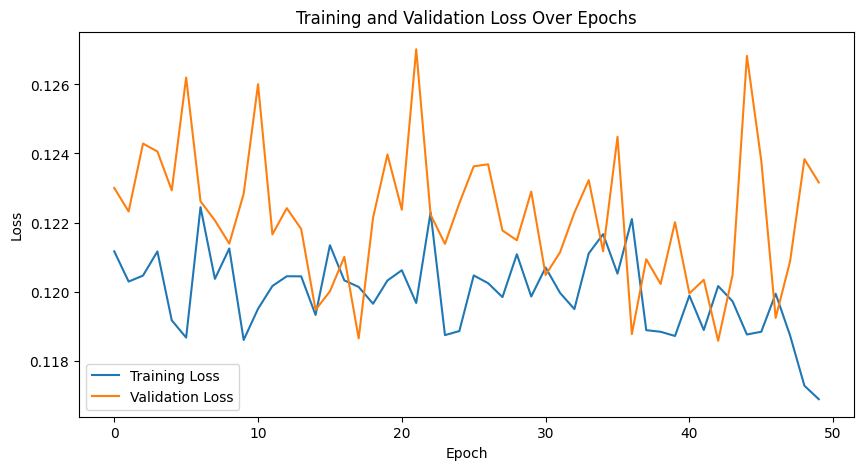

In [82]:
plot_errors(train_losses, val_losses)

### Hyperparameter selection

In [91]:
# Define the function to create the model architecture based on hyperparameters
def create_model(input_size, n_units1, n_units2, dropout_rate):
    model = nn.Sequential(
        nn.Linear(input_size, n_units1),
        nn.LeakyReLU(0.01),
        nn.BatchNorm1d(n_units1),
        nn.Dropout(dropout_rate),
        
        nn.Linear(n_units1, n_units2),
        nn.LeakyReLU(0.01),
        nn.BatchNorm1d(n_units2),
        nn.Dropout(dropout_rate),
        
        nn.Linear(n_units2, 10),
        nn.LeakyReLU(0.01),
        
        nn.Linear(10, 1)  # No Sigmoid here because we'll use BCEWithLogitsLoss
    )
    return model

In [92]:
# Define the objective function for Optuna optimization
def objective(trial):
    # Define the hyperparameters to tune
    n_units1 = trial.suggest_int("n_units1", 64, 256)  # Units in first hidden layer
    n_units2 = trial.suggest_int("n_units2", 16, 128)  # Units in second hidden layer
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)  # Learning rate
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)  # Weight decay

    # Create the model based on suggested hyperparameters
    model = create_model(X.shape[1], n_units1, n_units2, dropout_rate)
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for numerical stability
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Optional: Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Set the number of epochs for tuning
    num_epochs = 50  # You can increase this if you want longer training for better tuning

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for batch in train_loader:
            features, labels = batch
            labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape

            optimizer.zero_grad()
            outputs = model(features)  # Raw logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
    # Validation phase to calculate log loss on probabilities
    model.eval()
    val_probs = []
    val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            labels = labels.view(-1, 1)  # Ensure labels shape matches the output shape
            outputs = model(features)
            val_probs.append(torch.sigmoid(outputs).cpu().numpy())  # Convert logits to probabilities
            val_labels.append(labels.cpu().numpy())

    # Calculate validation log loss using sklearn log_loss
    val_probs = np.concatenate(val_probs)
    val_labels = np.concatenate(val_labels)
    val_log_loss = log_loss(val_labels, val_probs)  # Log loss for validation

    # Step the scheduler
    scheduler.step()

    # Print the validation log loss for this trial
    print(f"Trial {trial.number + 1}, Validation Log Loss: {val_log_loss:.4f}")

    # Return the final validation log loss as the metric for Optuna to optimize
    return val_log_loss

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the results of the best trial
print("Best trial:", study.best_trial)
print("Best params:", study.best_trial.params)

# Now, update model weights and biases using the best hyperparameters from Optuna
best_params = study.best_trial.params
best_model = create_model(X.shape[1], best_params["n_units1"], best_params["n_units2"], best_params["dropout_rate"])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

# Now you can proceed with training best_model on the entire training data
# or use it for inference/validation as needed.



[I 2024-10-07 11:09:48,286] A new study created in memory with name: no-name-18ed2cf5-50af-4b76-bde9-2d6f261d4eae
[I 2024-10-07 11:10:23,312] Trial 0 finished with value: 0.12363652860098684 and parameters: {'n_units1': 204, 'n_units2': 125, 'dropout_rate': 0.35703701786764686, 'lr': 0.001247261999549087, 'weight_decay': 0.0003136950539404169}. Best is trial 0 with value: 0.12363652860098684.


Trial 1, Validation Log Loss: 0.1236


[I 2024-10-07 11:10:58,288] Trial 1 finished with value: 0.11921695450213173 and parameters: {'n_units1': 89, 'n_units2': 127, 'dropout_rate': 0.42960940341471376, 'lr': 0.00035190134958024144, 'weight_decay': 9.220646038917157e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 2, Validation Log Loss: 0.1192


[I 2024-10-07 11:11:33,536] Trial 2 finished with value: 0.12474818373696535 and parameters: {'n_units1': 248, 'n_units2': 55, 'dropout_rate': 0.4400070490974616, 'lr': 0.00010002318906055606, 'weight_decay': 2.1856712758919064e-06}. Best is trial 1 with value: 0.11921695450213173.


Trial 3, Validation Log Loss: 0.1247


[I 2024-10-07 11:12:08,283] Trial 3 finished with value: 0.1309917103847432 and parameters: {'n_units1': 146, 'n_units2': 54, 'dropout_rate': 0.13382363530566896, 'lr': 0.009660853113275128, 'weight_decay': 5.015279037327842e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 4, Validation Log Loss: 0.1310


[I 2024-10-07 11:12:43,635] Trial 4 finished with value: 0.11952390079035555 and parameters: {'n_units1': 214, 'n_units2': 62, 'dropout_rate': 0.425294964312261, 'lr': 0.0003328800782594814, 'weight_decay': 0.00012423240046057038}. Best is trial 1 with value: 0.11921695450213173.


Trial 5, Validation Log Loss: 0.1195


[I 2024-10-07 11:13:18,623] Trial 5 finished with value: 0.14571217245739998 and parameters: {'n_units1': 77, 'n_units2': 107, 'dropout_rate': 0.48115595178908943, 'lr': 0.07306769459638351, 'weight_decay': 0.00010269986093345348}. Best is trial 1 with value: 0.11921695450213173.


Trial 6, Validation Log Loss: 0.1457


[I 2024-10-07 11:13:53,920] Trial 6 finished with value: 0.12364859848112536 and parameters: {'n_units1': 166, 'n_units2': 44, 'dropout_rate': 0.3322616623512952, 'lr': 0.0015682723044618998, 'weight_decay': 0.00016139144911051065}. Best is trial 1 with value: 0.11921695450213173.


Trial 7, Validation Log Loss: 0.1236


[I 2024-10-07 11:14:29,114] Trial 7 finished with value: 0.1557590000829221 and parameters: {'n_units1': 91, 'n_units2': 74, 'dropout_rate': 0.17260922479333876, 'lr': 0.04954526218078849, 'weight_decay': 0.00022313752741256435}. Best is trial 1 with value: 0.11921695450213173.


Trial 8, Validation Log Loss: 0.1558


[I 2024-10-07 11:15:05,142] Trial 8 finished with value: 0.14920795683236354 and parameters: {'n_units1': 189, 'n_units2': 99, 'dropout_rate': 0.10773955327659307, 'lr': 0.06623962588975281, 'weight_decay': 1.0389479843135592e-06}. Best is trial 1 with value: 0.11921695450213173.


Trial 9, Validation Log Loss: 0.1492


[I 2024-10-07 11:15:40,565] Trial 9 finished with value: 0.1280288673555669 and parameters: {'n_units1': 171, 'n_units2': 54, 'dropout_rate': 0.36093437743867707, 'lr': 0.008899001386509255, 'weight_decay': 1.6072058914071625e-06}. Best is trial 1 with value: 0.11921695450213173.


Trial 10, Validation Log Loss: 0.1280


[I 2024-10-07 11:16:16,589] Trial 10 finished with value: 0.1216590201236875 and parameters: {'n_units1': 120, 'n_units2': 17, 'dropout_rate': 0.221739421592726, 'lr': 0.00032812457875944136, 'weight_decay': 0.0009218905829048883}. Best is trial 1 with value: 0.11921695450213173.


Trial 11, Validation Log Loss: 0.1217


[I 2024-10-07 11:16:55,137] Trial 11 finished with value: 0.12044784482649677 and parameters: {'n_units1': 233, 'n_units2': 84, 'dropout_rate': 0.42016569040809515, 'lr': 0.00037613294888214684, 'weight_decay': 1.3620160404357716e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 12, Validation Log Loss: 0.1204


[I 2024-10-07 11:17:32,627] Trial 12 finished with value: 0.11988758982719157 and parameters: {'n_units1': 123, 'n_units2': 122, 'dropout_rate': 0.2769108342236921, 'lr': 0.00012383432145037141, 'weight_decay': 2.697404188650324e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 13, Validation Log Loss: 0.1199


[I 2024-10-07 11:18:10,142] Trial 13 finished with value: 0.12368767832221836 and parameters: {'n_units1': 222, 'n_units2': 89, 'dropout_rate': 0.4945893327642629, 'lr': 0.0007028527738135571, 'weight_decay': 8.598318066270717e-06}. Best is trial 1 with value: 0.11921695450213173.


Trial 14, Validation Log Loss: 0.1237


[I 2024-10-07 11:18:46,213] Trial 14 finished with value: 0.1289634160089061 and parameters: {'n_units1': 105, 'n_units2': 36, 'dropout_rate': 0.41218449095232884, 'lr': 0.0037611440079566467, 'weight_decay': 0.000584551622434842}. Best is trial 1 with value: 0.11921695450213173.


Trial 15, Validation Log Loss: 0.1290


[I 2024-10-07 11:19:22,745] Trial 15 finished with value: 0.12055160064391311 and parameters: {'n_units1': 69, 'n_units2': 69, 'dropout_rate': 0.27155646980644177, 'lr': 0.00018135660877754685, 'weight_decay': 7.30734525113064e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 16, Validation Log Loss: 0.1206


[I 2024-10-07 11:20:00,403] Trial 16 finished with value: 0.12144410960047906 and parameters: {'n_units1': 145, 'n_units2': 107, 'dropout_rate': 0.3881984185454818, 'lr': 0.0005233888999161802, 'weight_decay': 3.1843285761898194e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 17, Validation Log Loss: 0.1214


[I 2024-10-07 11:20:37,457] Trial 17 finished with value: 0.12311116317516664 and parameters: {'n_units1': 209, 'n_units2': 72, 'dropout_rate': 0.4444350023471857, 'lr': 0.002613746737181082, 'weight_decay': 9.81400841117804e-06}. Best is trial 1 with value: 0.11921695450213173.


Trial 18, Validation Log Loss: 0.1231


[I 2024-10-07 11:21:13,646] Trial 18 finished with value: 0.12012862702018491 and parameters: {'n_units1': 256, 'n_units2': 28, 'dropout_rate': 0.310177727960643, 'lr': 0.0002913068608624495, 'weight_decay': 0.00038766011489116615}. Best is trial 1 with value: 0.11921695450213173.


Trial 19, Validation Log Loss: 0.1201


[I 2024-10-07 11:21:49,325] Trial 19 finished with value: 0.12169309616874159 and parameters: {'n_units1': 180, 'n_units2': 86, 'dropout_rate': 0.46613436155511007, 'lr': 0.0009956652377264546, 'weight_decay': 0.00012598873890754022}. Best is trial 1 with value: 0.11921695450213173.


Trial 20, Validation Log Loss: 0.1217


[I 2024-10-07 11:22:25,043] Trial 20 finished with value: 0.12669914063101895 and parameters: {'n_units1': 198, 'n_units2': 62, 'dropout_rate': 0.3944841616231915, 'lr': 0.005119817502646025, 'weight_decay': 3.8972354855702366e-06}. Best is trial 1 with value: 0.11921695450213173.


Trial 21, Validation Log Loss: 0.1267


[I 2024-10-07 11:23:01,478] Trial 21 finished with value: 0.12101976228863216 and parameters: {'n_units1': 129, 'n_units2': 125, 'dropout_rate': 0.2616559334656551, 'lr': 0.00010171898797786273, 'weight_decay': 2.3136537133191065e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 22, Validation Log Loss: 0.1210


[I 2024-10-07 11:23:38,212] Trial 22 finished with value: 0.12269763139790564 and parameters: {'n_units1': 104, 'n_units2': 116, 'dropout_rate': 0.22334617813321558, 'lr': 0.00019226805599017248, 'weight_decay': 4.7572172313671474e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 23, Validation Log Loss: 0.1227


[I 2024-10-07 11:24:16,573] Trial 23 finished with value: 0.12563877021873932 and parameters: {'n_units1': 120, 'n_units2': 128, 'dropout_rate': 0.30145406241538497, 'lr': 0.0001623379582649489, 'weight_decay': 2.101572674733589e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 24, Validation Log Loss: 0.1256


[I 2024-10-07 11:24:54,291] Trial 24 finished with value: 0.12366131219534268 and parameters: {'n_units1': 144, 'n_units2': 114, 'dropout_rate': 0.34905876117308304, 'lr': 0.0004985590002847693, 'weight_decay': 7.14998768366614e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 25, Validation Log Loss: 0.1237


[I 2024-10-07 11:25:31,127] Trial 25 finished with value: 0.1204978271801262 and parameters: {'n_units1': 87, 'n_units2': 98, 'dropout_rate': 0.26542343570043386, 'lr': 0.00022089428347089722, 'weight_decay': 4.233970925301788e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 26, Validation Log Loss: 0.1205


[I 2024-10-07 11:26:07,901] Trial 26 finished with value: 0.12318942272094231 and parameters: {'n_units1': 102, 'n_units2': 116, 'dropout_rate': 0.21514708283403614, 'lr': 0.0008099303612303015, 'weight_decay': 8.537978002602989e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 27, Validation Log Loss: 0.1232


[I 2024-10-07 11:26:44,786] Trial 27 finished with value: 0.14132032574947498 and parameters: {'n_units1': 130, 'n_units2': 96, 'dropout_rate': 0.3772709289750673, 'lr': 0.020838174336364892, 'weight_decay': 0.00019254793460242065}. Best is trial 1 with value: 0.11921695450213173.


Trial 28, Validation Log Loss: 0.1413


[I 2024-10-07 11:27:21,514] Trial 28 finished with value: 0.1244683952627158 and parameters: {'n_units1': 65, 'n_units2': 108, 'dropout_rate': 0.32075338098772155, 'lr': 0.0024317141112033653, 'weight_decay': 5.395372978998873e-06}. Best is trial 1 with value: 0.11921695450213173.


Trial 29, Validation Log Loss: 0.1245


[I 2024-10-07 11:27:58,699] Trial 29 finished with value: 0.12579925266600323 and parameters: {'n_units1': 156, 'n_units2': 120, 'dropout_rate': 0.46296523772970744, 'lr': 0.0014939942324554076, 'weight_decay': 0.0003960053585543734}. Best is trial 1 with value: 0.11921695450213173.


Trial 30, Validation Log Loss: 0.1258


[I 2024-10-07 11:28:32,570] Trial 30 finished with value: 0.12561852620639788 and parameters: {'n_units1': 85, 'n_units2': 80, 'dropout_rate': 0.3465048086150205, 'lr': 0.00014143237943507145, 'weight_decay': 1.6190800201773274e-05}. Best is trial 1 with value: 0.11921695450213173.


Trial 31, Validation Log Loss: 0.1256


[I 2024-10-07 11:29:06,809] Trial 31 finished with value: 0.12152982450787445 and parameters: {'n_units1': 244, 'n_units2': 21, 'dropout_rate': 0.2945987602811264, 'lr': 0.00035254249431720166, 'weight_decay': 0.00031038722440503315}. Best is trial 1 with value: 0.11921695450213173.


Trial 32, Validation Log Loss: 0.1215


[I 2024-10-07 11:29:41,102] Trial 32 finished with value: 0.12225425757814369 and parameters: {'n_units1': 253, 'n_units2': 32, 'dropout_rate': 0.4404295492453856, 'lr': 0.00030598650783712934, 'weight_decay': 0.0004208363817667576}. Best is trial 1 with value: 0.11921695450213173.


Trial 33, Validation Log Loss: 0.1223


[I 2024-10-07 11:30:15,877] Trial 33 finished with value: 0.12589409376656477 and parameters: {'n_units1': 215, 'n_units2': 44, 'dropout_rate': 0.4137085004033775, 'lr': 0.0001110916006885505, 'weight_decay': 0.00022812222692423551}. Best is trial 1 with value: 0.11921695450213173.


Trial 34, Validation Log Loss: 0.1259


[I 2024-10-07 11:30:50,212] Trial 34 finished with value: 0.12259846676560503 and parameters: {'n_units1': 236, 'n_units2': 27, 'dropout_rate': 0.19299739730516624, 'lr': 0.0002479131405833934, 'weight_decay': 0.0006051422374037343}. Best is trial 1 with value: 0.11921695450213173.


Trial 35, Validation Log Loss: 0.1226


[I 2024-10-07 11:31:25,714] Trial 35 finished with value: 0.11851904515889598 and parameters: {'n_units1': 256, 'n_units2': 60, 'dropout_rate': 0.30393767646782444, 'lr': 0.0004940211552825393, 'weight_decay': 0.0001306593960095015}. Best is trial 35 with value: 0.11851904515889598.


Trial 36, Validation Log Loss: 0.1185


[I 2024-10-07 11:32:00,569] Trial 36 finished with value: 0.12615267998704713 and parameters: {'n_units1': 220, 'n_units2': 64, 'dropout_rate': 0.2486600878110511, 'lr': 0.0005377930817105772, 'weight_decay': 0.00011721653274446977}. Best is trial 35 with value: 0.11851904515889598.


Trial 37, Validation Log Loss: 0.1262


[I 2024-10-07 11:32:35,420] Trial 37 finished with value: 0.12455643558502363 and parameters: {'n_units1': 201, 'n_units2': 60, 'dropout_rate': 0.28475666450525355, 'lr': 0.0010621419817472251, 'weight_decay': 5.464893906778277e-05}. Best is trial 35 with value: 0.11851904515889598.


Trial 38, Validation Log Loss: 0.1246


[I 2024-10-07 11:33:10,483] Trial 38 finished with value: 0.11969253540555258 and parameters: {'n_units1': 228, 'n_units2': 45, 'dropout_rate': 0.32994826165974306, 'lr': 0.0006249215221886548, 'weight_decay': 0.0001392846997857794}. Best is trial 35 with value: 0.11851904515889598.


Trial 39, Validation Log Loss: 0.1197


[I 2024-10-07 11:33:44,981] Trial 39 finished with value: 0.12295995753412473 and parameters: {'n_units1': 232, 'n_units2': 46, 'dropout_rate': 0.3759465799849882, 'lr': 0.0015433294073274946, 'weight_decay': 0.0001508734436510656}. Best is trial 35 with value: 0.11851904515889598.


Trial 40, Validation Log Loss: 0.1230


[I 2024-10-07 11:34:19,922] Trial 40 finished with value: 0.11930890734139975 and parameters: {'n_units1': 192, 'n_units2': 47, 'dropout_rate': 0.3361451928123755, 'lr': 0.0007309419150151612, 'weight_decay': 0.00024965383300212275}. Best is trial 35 with value: 0.11851904515889598.


Trial 41, Validation Log Loss: 0.1193


[I 2024-10-07 11:34:54,989] Trial 41 finished with value: 0.12219869132413104 and parameters: {'n_units1': 190, 'n_units2': 51, 'dropout_rate': 0.3347858571334062, 'lr': 0.0006954463500462413, 'weight_decay': 0.0002664095506441035}. Best is trial 35 with value: 0.11851904515889598.


Trial 42, Validation Log Loss: 0.1222


[I 2024-10-07 11:35:29,969] Trial 42 finished with value: 0.12094551810603268 and parameters: {'n_units1': 245, 'n_units2': 38, 'dropout_rate': 0.3658998884734569, 'lr': 0.00048372852148988264, 'weight_decay': 0.00015774407598663926}. Best is trial 35 with value: 0.11851904515889598.


Trial 43, Validation Log Loss: 0.1209


[I 2024-10-07 11:36:05,105] Trial 43 finished with value: 0.1271598294686791 and parameters: {'n_units1': 223, 'n_units2': 50, 'dropout_rate': 0.32168140108920346, 'lr': 0.000908658332897898, 'weight_decay': 9.992698587039147e-05}. Best is trial 35 with value: 0.11851904515889598.


Trial 44, Validation Log Loss: 0.1272


[I 2024-10-07 11:36:40,290] Trial 44 finished with value: 0.12400318572578835 and parameters: {'n_units1': 238, 'n_units2': 57, 'dropout_rate': 0.3966569927461227, 'lr': 0.00041939266645824855, 'weight_decay': 0.00020145702428403493}. Best is trial 35 with value: 0.11851904515889598.


Trial 45, Validation Log Loss: 0.1240


[I 2024-10-07 11:37:15,909] Trial 45 finished with value: 0.12211871694851999 and parameters: {'n_units1': 177, 'n_units2': 67, 'dropout_rate': 0.3422981063644094, 'lr': 0.002054525836516748, 'weight_decay': 6.614885967580181e-05}. Best is trial 35 with value: 0.11851904515889598.


Trial 46, Validation Log Loss: 0.1221


[I 2024-10-07 11:37:51,713] Trial 46 finished with value: 0.12078883685890109 and parameters: {'n_units1': 208, 'n_units2': 42, 'dropout_rate': 0.46528561425241316, 'lr': 0.0006269484518079799, 'weight_decay': 0.00011142701936480964}. Best is trial 35 with value: 0.11851904515889598.


Trial 47, Validation Log Loss: 0.1208


[I 2024-10-07 11:38:28,289] Trial 47 finished with value: 0.1232583418904709 and parameters: {'n_units1': 193, 'n_units2': 79, 'dropout_rate': 0.4277167499859601, 'lr': 0.0011394503076044473, 'weight_decay': 0.0005742056365159862}. Best is trial 35 with value: 0.11851904515889598.


Trial 48, Validation Log Loss: 0.1233


[I 2024-10-07 11:39:03,530] Trial 48 finished with value: 0.12579835218702362 and parameters: {'n_units1': 230, 'n_units2': 57, 'dropout_rate': 0.13866287020076634, 'lr': 0.0002389538247662702, 'weight_decay': 0.00014421658843817326}. Best is trial 35 with value: 0.11851904515889598.


Trial 49, Validation Log Loss: 0.1258


[I 2024-10-07 11:39:38,561] Trial 49 finished with value: 0.12531956081444268 and parameters: {'n_units1': 183, 'n_units2': 49, 'dropout_rate': 0.49057211895120034, 'lr': 0.004018322980618668, 'weight_decay': 4.094737281679776e-05}. Best is trial 35 with value: 0.11851904515889598.


Trial 50, Validation Log Loss: 0.1253
Best trial: FrozenTrial(number=35, state=TrialState.COMPLETE, values=[0.11851904515889598], datetime_start=datetime.datetime(2024, 10, 7, 11, 30, 50, 212503), datetime_complete=datetime.datetime(2024, 10, 7, 11, 31, 25, 713829), params={'n_units1': 256, 'n_units2': 60, 'dropout_rate': 0.30393767646782444, 'lr': 0.0004940211552825393, 'weight_decay': 0.0001306593960095015}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_units1': IntDistribution(high=256, log=False, low=64, step=1), 'n_units2': IntDistribution(high=128, log=False, low=16, step=1), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'lr': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-06, step=None)}, trial_id=35, value=None)
Best params: {'n_units1': 256, 'n_units2': 60, 'dropout_rate': 0.30393767646782444, 'lr': 0.0004940211552825393, 'weight_decay': 0.000

### Training with the Best Parameters

Epoch [1/50] - Train Loss: 0.2138, Validation Loss: 0.1423
Epoch [2/50] - Train Loss: 0.1390, Validation Loss: 0.1293
Epoch [3/50] - Train Loss: 0.1319, Validation Loss: 0.1283
Epoch [4/50] - Train Loss: 0.1337, Validation Loss: 0.1259
Epoch [5/50] - Train Loss: 0.1307, Validation Loss: 0.1271
Epoch [6/50] - Train Loss: 0.1279, Validation Loss: 0.1260
Epoch [7/50] - Train Loss: 0.1294, Validation Loss: 0.1264
Epoch [8/50] - Train Loss: 0.1308, Validation Loss: 0.1247
Epoch [9/50] - Train Loss: 0.1271, Validation Loss: 0.1205
Epoch [10/50] - Train Loss: 0.1275, Validation Loss: 0.1221
Epoch [11/50] - Train Loss: 0.1276, Validation Loss: 0.1263
Epoch [12/50] - Train Loss: 0.1258, Validation Loss: 0.1240
Epoch [13/50] - Train Loss: 0.1244, Validation Loss: 0.1206
Epoch [14/50] - Train Loss: 0.1244, Validation Loss: 0.1220
Epoch [15/50] - Train Loss: 0.1230, Validation Loss: 0.1199
Epoch [16/50] - Train Loss: 0.1237, Validation Loss: 0.1255
Epoch [17/50] - Train Loss: 0.1239, Validation Lo

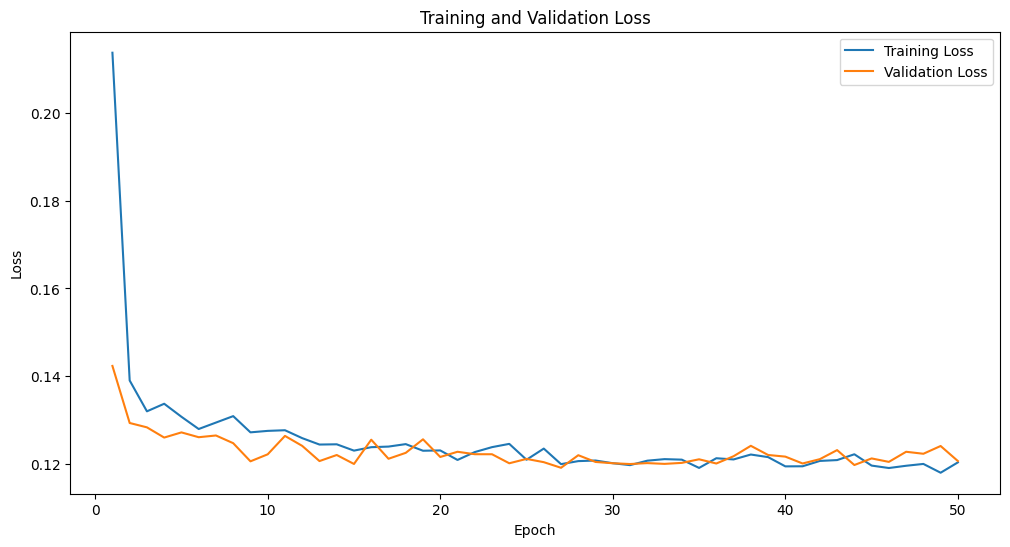

Test Set Performance: Log Loss: 0.1152, AUC: 0.8889, Brier Score: 0.0306


In [95]:
# Function to perform a single training epoch
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for features, labels in train_loader:
        labels = labels.view(-1, 1)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    return avg_train_loss

# Function to validate the model
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_probs = []
    val_labels = []
    
    with torch.no_grad():
        for features, labels in val_loader:
            labels = labels.view(-1, 1)
            outputs = model(features)
            val_loss += criterion(outputs, labels).item()  # Accumulate validation loss
            val_probs.append(torch.sigmoid(outputs).cpu().numpy())
            val_labels.append(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_probs = np.concatenate(val_probs)
    val_labels = np.concatenate(val_labels)
    
    return avg_val_loss, val_probs, val_labels

# Function to plot training and validation losses
def plot_losses(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Get best parameters from Optuna and create a model
best_params = study.best_trial.params
model = create_model(X.shape[1], best_params["n_units1"], best_params["n_units2"], best_params["dropout_rate"])
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])
criterion = nn.BCEWithLogitsLoss()
num_epochs = 50

# Lists to track performance
train_losses = []
val_losses = []

# Train the model with the best parameters
for epoch in range(num_epochs):
    avg_train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(avg_train_loss)
    
    # Validate the model
    avg_val_loss, val_probs, val_labels = validate_model(model, val_loader, criterion)
    val_losses.append(avg_val_loss)

    # Print average losses for this epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot training and validation loss using the plotting function
plot_losses(train_losses, val_losses, num_epochs)

# Evaluate the model on the test set
model.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    for data in test_loader:
        features, labels = data
        labels = labels.view(-1, 1)
        outputs = model(features)
        probs = torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities
        test_probs.extend(probs)
        test_labels.extend(labels.cpu().numpy())

# Ensure test_labels and test_probs are flattened
test_labels = np.array(test_labels).flatten()
test_probs = np.array(test_probs).flatten()

# Calculate performance metrics on the test set
test_log_loss = log_loss(test_labels, test_probs)
test_auc = roc_auc_score(test_labels, test_probs)
test_brier = brier_score_loss(test_labels, test_probs)

print(f"Test Set Performance: Log Loss: {test_log_loss:.4f}, AUC: {test_auc:.4f}, Brier Score: {test_brier:.4f}")



### Updating Weights and Re-Evaluation
- Trains a model for 20 epochs, manually updating the weights and biases of the first layer at each step, instead of relying on a built-in optimizer.
- Calculates and prints the average loss for each epoch.
- Shows a more granular control over the training process, as you’re directly manipulating the model parameters based on computed gradients.

In [97]:
# Now, update model weights and biases using the best hyperparameters from Optuna
best_params = study.best_trial.params
best_model = create_model(X.shape[1], best_params["n_units1"], best_params["n_units2"], best_params["dropout_rate"])
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for numerical stability
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    best_model.train()  # Set the model to training mode
    total_loss = 0.0  # Initialize total loss for the epoch
    
    for data in train_loader:
        features, labels = data
        labels = labels.view(-1, 1)  # Ensure correct shape for binary targets

        # Forward pass
        outputs = best_model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization step
        best_optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()  # Backpropagate the loss
        best_optimizer.step()  # Update model parameters
        
        # Accumulate the loss
        total_loss += loss.item()
    
    # Calculate and print the average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# After training, you can evaluate the model on the validation or test set as needed.



Epoch [1/50], Loss: 0.2038
Epoch [2/50], Loss: 0.1360
Epoch [3/50], Loss: 0.1352
Epoch [4/50], Loss: 0.1311
Epoch [5/50], Loss: 0.1296
Epoch [6/50], Loss: 0.1288
Epoch [7/50], Loss: 0.1266
Epoch [8/50], Loss: 0.1260
Epoch [9/50], Loss: 0.1268
Epoch [10/50], Loss: 0.1273
Epoch [11/50], Loss: 0.1252
Epoch [12/50], Loss: 0.1254
Epoch [13/50], Loss: 0.1262
Epoch [14/50], Loss: 0.1248
Epoch [15/50], Loss: 0.1236
Epoch [16/50], Loss: 0.1227
Epoch [17/50], Loss: 0.1220
Epoch [18/50], Loss: 0.1230
Epoch [19/50], Loss: 0.1246
Epoch [20/50], Loss: 0.1236
Epoch [21/50], Loss: 0.1202
Epoch [22/50], Loss: 0.1225
Epoch [23/50], Loss: 0.1221
Epoch [24/50], Loss: 0.1230
Epoch [25/50], Loss: 0.1219
Epoch [26/50], Loss: 0.1210
Epoch [27/50], Loss: 0.1200
Epoch [28/50], Loss: 0.1225
Epoch [29/50], Loss: 0.1222
Epoch [30/50], Loss: 0.1221
Epoch [31/50], Loss: 0.1228
Epoch [32/50], Loss: 0.1214
Epoch [33/50], Loss: 0.1242
Epoch [34/50], Loss: 0.1210
Epoch [35/50], Loss: 0.1210
Epoch [36/50], Loss: 0.1243
E

Epoch [1/50] - Train Loss: 0.2688, Validation Loss: 0.1448
Epoch [2/50] - Train Loss: 0.1410, Validation Loss: 0.1321
Epoch [3/50] - Train Loss: 0.1357, Validation Loss: 0.1343
Epoch [4/50] - Train Loss: 0.1339, Validation Loss: 0.1288
Epoch [5/50] - Train Loss: 0.1346, Validation Loss: 0.1264
Epoch [6/50] - Train Loss: 0.1295, Validation Loss: 0.1252
Epoch [7/50] - Train Loss: 0.1292, Validation Loss: 0.1260
Epoch [8/50] - Train Loss: 0.1311, Validation Loss: 0.1219
Epoch [9/50] - Train Loss: 0.1282, Validation Loss: 0.1212
Epoch [10/50] - Train Loss: 0.1271, Validation Loss: 0.1245
Epoch [11/50] - Train Loss: 0.1247, Validation Loss: 0.1279
Epoch [12/50] - Train Loss: 0.1275, Validation Loss: 0.1282
Epoch [13/50] - Train Loss: 0.1235, Validation Loss: 0.1211
Epoch [14/50] - Train Loss: 0.1246, Validation Loss: 0.1207
Epoch [15/50] - Train Loss: 0.1262, Validation Loss: 0.1199
Epoch [16/50] - Train Loss: 0.1231, Validation Loss: 0.1211
Epoch [17/50] - Train Loss: 0.1222, Validation Lo

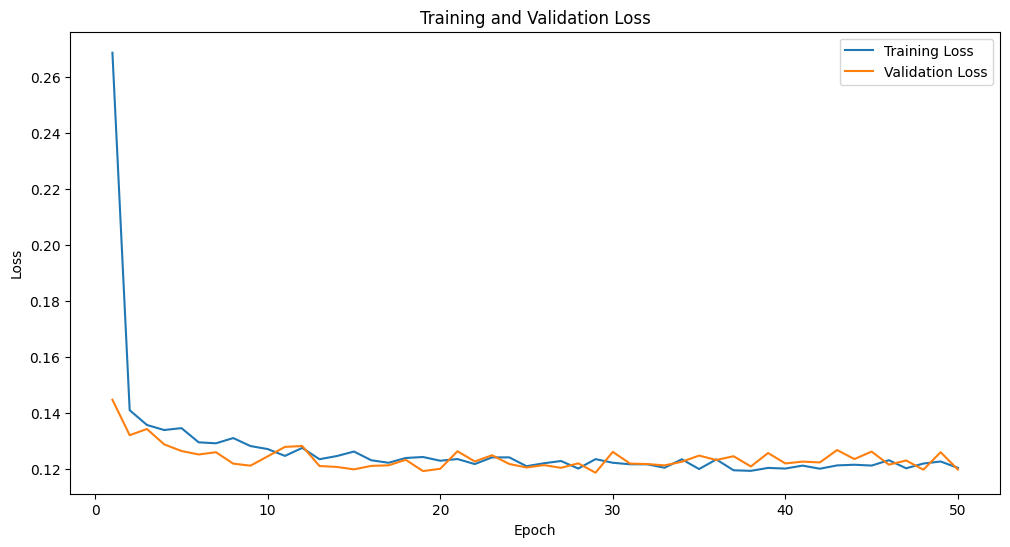

Test Set Performance: Log Loss: 0.1156, AUC: 0.8874, Brier Score: 0.0307


In [98]:
# Function to evaluate the model on a dataset (train, validation, or test)
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    probs = []
    labels = []
    
    with torch.no_grad():
        for features, label in data_loader:
            label = label.view(-1, 1)  # Ensure correct shape
            output = model(features)
            total_loss += criterion(output, label).item()  # Accumulate loss
            probs.append(torch.sigmoid(output).cpu().numpy())  # Convert logits to probabilities
            labels.append(label.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    probs = np.concatenate(probs)
    labels = np.concatenate(labels)
    
    return avg_loss, probs, labels

# Get best parameters from Optuna and create a model
best_params = study.best_trial.params
model = create_model(X.shape[1], best_params["n_units1"], best_params["n_units2"], best_params["dropout_rate"])
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])
criterion = nn.BCEWithLogitsLoss()
num_epochs = 50

# Lists to track performance
train_losses = []
val_losses = []

# Train the model with the best parameters
for epoch in range(num_epochs):
    avg_train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(avg_train_loss)

    # Validate the model
    avg_val_loss, val_probs, val_labels = validate_model(model, val_loader, criterion)
    val_losses.append(avg_val_loss)

    # Print average losses for this epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Plot training and validation loss
plot_losses(train_losses, val_losses, num_epochs)

# Evaluate the model on the test set using the evaluate_model function
test_log_loss, test_probs, test_labels = evaluate_model(model, test_loader, criterion)

# Calculate performance metrics on the test set
test_auc = roc_auc_score(test_labels, test_probs)
test_brier = brier_score_loss(test_labels, test_probs)

print(f"Test Set Performance: Log Loss: {test_log_loss:.4f}, AUC: {test_auc:.4f}, Brier Score: {test_brier:.4f}")


In [2]:
# Step 1: Convert X_final_test to tensor and create DataLoader for the test set
test_features = torch.tensor(X_final_test.to_numpy()).float()
test_dataset = TensorDataset(test_features)  # If you don't have labels, you can use just features
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Step 2: Set model to evaluation mode and make predictions
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        features = data[0]  # Extract features from the dataset
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())  # Collect predictions as numpy array

# Step 3: Convert predictions to numpy array and add to DataFrame
predictions = np.array(predictions).flatten()

NameError: name 'torch' is not defined

In [ ]:
y_probs = model.predict_proba(X_test)
print("Log Loss:", log_loss(y_test, y_probs))
print("Brier Score:", brier_score_loss(y_test, y_probs))
print("AUC-ROC:", roc_auc_score(y_test, y_probs))

In [211]:
# X0 = filtered_data[["d", "r2", "min_MAF", "diff_MAF", "log10_distance", "error"]]
# y0 = filtered_data["error"]
# # Split the data into train and test using the same random_state and test_size as before
# _, X0_test, _, _ = train_test_split(
#     X0, y0, test_size=0.25, random_state=42, stratify=y
# )

In [212]:
# X0_test['NN_model4_pred'] = predictions
# X0_test

,d,r2,min_MAF,diff_MAF,log10_distance,error,NN_model4_pred
3328,1.0,0.001,0.0010,0.1402,1.716003,0.0,0.042982
14002,1.0,0.057,0.1561,0.0497,2.471292,0.0,0.020441
8269,0.2,0.033,0.0845,0.3111,4.856904,0.0,0.174293
6710,1.0,0.002,0.4076,0.0000,2.214844,0.0,0.001667
11897,1.0,0.068,0.0765,0.2883,2.648360,0.0,0.052889
...,...,...,...,...,...,...,...
10914,1.0,1.000,0.3728,0.0000,1.886491,0.0,0.000433
5080,1.0,0.613,0.1491,0.0557,2.737193,0.0,0.013221
2519,1.0,0.230,0.0497,0.2366,4.723850,0.0,0.129702
12044,1.0,0.037,0.0298,0.4026,2.957128,0.0,0.094741


In [1]:
X0_test['NN_model2_pred'] = predictions
X0_test

NameError: name 'predictions' is not defined

In [213]:
# # Save the model's state dictionary
# model_path = "/home/scarlett/github/Python/ipython_notebook/Coding/nn_model4"  # Replace 'model_name' with your desired file name
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")


Model saved to /home/scarlett/github/Python/ipython_notebook/Coding/nn_model4


In [226]:
# Save the model's state dictionary
model_path = "/home/scarlett/github/Python/ipython_notebook/Coding/nn_model3"  # Replace 'model_name' with your desired file name
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /home/scarlett/github/Python/ipython_notebook/Coding/nn_model3


In [146]:
# Define the model architecture (the same as when you trained it)
model = nn.Sequential(
    nn.Linear(X.shape[1], n_units),  # Replace 'n_units' with the appropriate size
    nn.ReLU(),
    nn.Dropout(dropout_rate),       # Replace 'dropout_rate' with the appropriate value
    nn.Linear(n_units, 1),
    nn.Sigmoid()
)

# Load the model's state dictionary
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for predictions.")


Model loaded and ready for predictions.
